# Fitting compartmental models to generation time distributions

In [17]:
using OrdinaryDiffEq,Plots,Distributions,SparseArrays,Distances,QuadGK

In [2]:
function create_rate_matrix(p)
    σ₁, σ₂, γ,β = p
    Q = spzeros(4,4)
    Q[2,1] = σ₁ #E->P
    Q[3,2] = σ₂ #P->I
    Q[4,3] = γ #I->R
    for k = 1:4
        Q[k,k] = -sum(Q[:,k])
    end
    return Q
end


create_rate_matrix (generic function with 1 method)

In [3]:
p = [1/3.1,1/2,1/7.,2/9.]
Q = create_rate_matrix(p)
L = DiffEqArrayOperator(Q) 

DiffEqArrayOperator{Float64,SparseMatrixCSC{Float64,Int64},typeof(DiffEqBase.DEFAULT_UPDATE_FUNC)}(
  [1, 1]  =  -0.322581
  [2, 1]  =  0.322581
  [2, 2]  =  -0.5
  [3, 2]  =  0.5
  [3, 3]  =  -0.142857
  [4, 3]  =  0.142857, DiffEqBase.DEFAULT_UPDATE_FUNC)

  0.000118 seconds (395 allocations: 41.453 KiB)


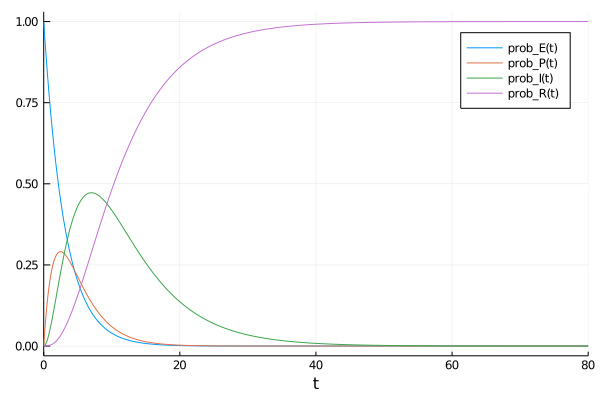

In [7]:
# function f(du,u,p,t)
#     du .= Q*u
# end
u0 = [1.,0.,0.,0.]
tspan = (0,80.)
ff = ODEFunction(L,syms = [:prob_E,:prob_P,:prob_I,:prob_R])
prob = ODEProblem(ff,u0,tspan,p)
@time sol = solve(prob,Tsit5())




plot(sol)

In [64]:


function generation_time_from_sol(sol)
    p = sol.prob.p
    σ₁, σ₂, γ,β = p
    R₀ = β*((1/σ₂) + (1/γ) )
    return t -> sum(sol(t).*[0.,β,β,0])/R₀
end


generation_time_from_sol (generic function with 1 method)

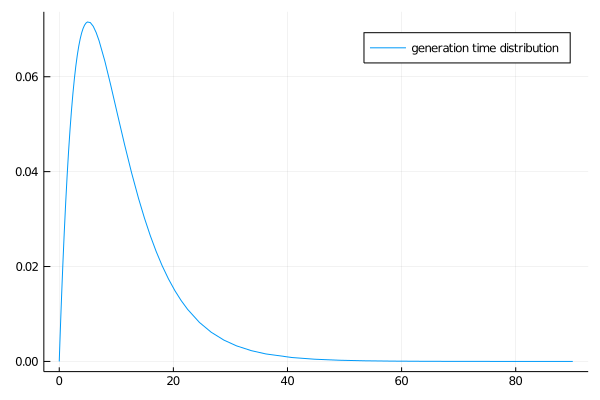

In [65]:
w_t = generation_time_from_sol(sol)
plt = plot(w_t,0.,90.,lab = "generation time distribution")
# d_gen_time = Weibull(2.826,5.665)
# fitted_gen_time = [pdf(d_gen_time,t) for t in 0:0.1:90]
# plot!(plt,0:0.1:90.,fitted_gen_time,lab = "Ferreti et al fit")

In [66]:
quadgk(w_t,0.,90.)[1]

0.9999943359981922

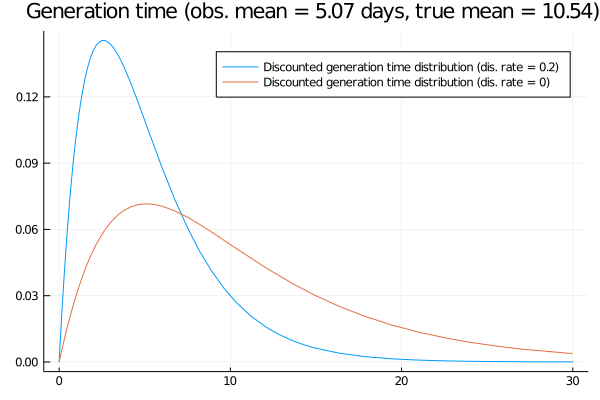

In [70]:
#discounted version
function discounted_w_t(w_t,λ)
    norm_const = quadgk(t-> w_t(t)*exp(-λ*t),0.,100.)[1]
    dw_t(t) = w_t(t)*exp(-λ*t)/norm_const
    return dw_t
end
λ = 0.2
dw_t = discounted_w_t(w_t,λ)
plt = plot(dw_t,0.,30.,lab = "Discounted generation time distribution (dis. rate = $λ)",
            title = "Generation time (obs. mean = $(round(quadgk(t-> t*dw_t(t),0.,100.)[1],digits = 2)) days, true mean = $(round(quadgk(t-> t*discounted_w_t(w_t,0.)(t),0.,100.)[1],digits = 2))))")
plot!(discounted_w_t(w_t,0.),0.,30.,lab = "Discounted generation time distribution (dis. rate = 0)")



In [147]:
function rel_entropy(w_t)
    p_w = [w_t(t) for t in 0.:0.1:20. ]
    return  0.1*sum([p_w.*(log.(p_w) .- log.(fitted_gen_time))])
end
log.([w_t(t) for t in 0.:0.1:20. ]) .- log.(fitted_gen_time)

201-element Array{Float64,1}:
 NaN                  
  -0.4735881332254639 
  -0.2203776401809865 
  -0.05523887887081802
   0.06301070775347828
   0.150684004616096  
   0.2165187380553233 
   0.2658887023794696 
   0.30240594797514797
   0.3286191804655667 
   0.3464284686639614 
   0.3572600076831911 
   0.36225744295914586
   ⋮                  
  22.391979151903932  
  22.801453197320306  
  23.21534441482065   
  23.63367094347061   
  24.056448425094104  
  24.48369561359046   
  24.91543269091442   
  25.35167963952102   
  25.792456232632304  
  26.237782025734383  
  26.687676349552557  
  27.142158304775336  

In [153]:
kl_divergence([w_t(t) for t in 0.:0.1:30. ],[pdf(d_gen_time,t) for t in 0:0.1:30])

7.368925740490218